**NER_REGEX**

In [23]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython.display import Image
#from IPython.display import display
#from time import gmtime, strftime
#from sagemaker.predictor import csv_serializer
#from sagemaker.session import s3_input, Session

In [24]:
import spacy
from spacy.tokens import Span
spacy.__version__

'3.3.0'

In [25]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model_price_senti = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Requirement already up-to-date: sentence-transformers in /opt/conda/lib/python3.6/site-packages (2.2.2)


In [26]:
import re
import os

In [27]:
nlp_reg=spacy.blank('en')
ruler = nlp_reg.add_pipe("entity_ruler")

In [28]:
# True regular expressions:-
# For price categorization:- "[Rr][Ss][\.]?[\s]?\d+[,]?\d+"
# For weight categorization:- "\d+[\.]?\d+\s[Kk][Gg]"
# For size categorization:- "\d+[\.]?\d+\s[Ii][Nn][Cc][Hh]e?E?s?S?"

colours = ["red","blue","green","yellow","purple","pink","orange","brown","black","white","gray","gold","silver","teal","indigo","magenta","violet","khaki","salmon","crimson","lavender","plum","olive","cyan","maroon","beige"]
brands = ["hp","asus","acer","dell","msi","acer","lenovo"]

# We initiate a new empty list patterns which will store all the patterns and rules off of which our model will predict the entities
patterns = []

# Coming to our first entity price, the user will generally write Rs or rs or Rs. or some sort of currency while writing a price.
# Using this information, we can write our own regular expressions for matching pattern and extracting all the domain specific entries which
# our older model is not able to predict correctly.

patterns.append({"label":"price", "pattern": [{"TEXT" : {"REGEX": "[Rr][Ss]"}},
                                              {"TEXT" : {"REGEX": "[\.]"}},
                                              {"TEXT" : {"REGEX": "\s*\d+"}}]})

# For our second entity weight, we can write the regular expression as well since we know that the user is going to type something like 2.5 kg 

patterns.append({"label":"weight", "pattern": [{"TEXT" : {"REGEX": "\d+"}}, 
                                               {"TEXT" : {"REGEX": "[Kk][Gg|Ii][Ll]?[Ll]?[Oo]?[Gg]?[Rr]?[Aa]?[Mm]?[Ss]?"}}]})

# Similarly for screen size, our user is going to give an input in inches. It can be used to write the regex.

patterns.append({"label":"size", "pattern": [{"TEXT" : {"REGEX": "\d+"}}, 
                                             {"TEXT" : {"REGEX": "[Ii][Nn]?[Cc]?[Hh]?[eE]?[sS]?"}}]})

patterns.append({"label":"ram", "pattern": [{"TEXT" : {"REGEX": "\d+"}}, 
                                             {"TEXT" : {"REGEX": "[Gg][Bb|Ii][Gg]?[Ss|Aa]?[Bb]?[Ii|Yy]?[Tt]?[Ee]?[Ss]?"}}]})

# Now coming to the cases when we already have a set list of products/colours or any other entities in general which we know that we want to detect
# from. So, for such cases, it is better to store them in a list and then iterate through them which defining the pattern for our model.

# In our case, we have stored the colours and brand names in a list since we will be having the product_list database. 

for brand in brands:
  patterns.append({"label":"brand", "pattern": [{"LOWER": brand}]})
for colour in colours:
  patterns.append({"label":"colour", "pattern": [{"LOWER": colour}]})

In [29]:
ruler.add_patterns(patterns)

In [30]:
pat_label = {"price_senti":"\w+[\s]\w+[\s][Rr][\s]?[Ss][\.]?[\s]?\d*[,]?\d*",
             "price_range":"[Rr][\s]?[Ss][\.]?[\s]?\d*[,]?\d*[\s]?[t|a]?[o|n]?[-|d]?[\s]?[Rr][\s]?[Ss][\.]?[\s]?\d*[,]?\d*",
             "weight_senti":"\w+[\s]\w+[\s]\w+\d*[\.]?\d*[\s][Kk][Gg|Ii][Ll]?[Ll]?[Oo]?[Gg]?[Rr]?[Aa]?[Mm]?[Ss]?",
             "weight_range":"\d*[\.]?\d*[\s][Kk][Gg|Ii][Ll]?[Ll]?[Oo]?[Gg]?[Rr]?[Aa]?[Mm]?[Ss]?[\s]?[t|a]?[o|n]?[-|d]?[\s]?\d*[\.]?\d*[\s][Kk][Gg|Ii][Ll]?[Ll]?[Oo]?[Gg]?[Rr]?[Aa]?[Mm]?[Ss]?",
             "size_senti":"\w+[\s]\w+[\s]\w+\d*[\.]?\d*[\s][I|i][N|n][C|c][H|h][e|E]?[s|S]?",
             "size_range":"\d*[\.]?\d*[\s][I|i][N|n][C|c][H|h][e|E]?[s|S]?[\s]?[t|a]?[o|n]?[-|d]?[\s]?\d*[\.]?\d*[\s][I|i][N|n][C|c][H|h][e|E]?[s|S]?",
             "ram_senti":"\w+[\s]\w+[\s]\w+\d*[\.]?\d*[\s][Gg][Bb|Ii][Gg]?[Ss|Aa]?[Bb]?[Ii|Yy]?[Tt]?[Ee]?[Ss]?",
             "ram_range":"\d*[Gg][Bb|Ii][Gg]?[Ss|Aa]?[Bb]?[Ii|Yy]?[Tt]?[Ee]?[Ss]?[\s]?[t|a]?[o|n]?[-|d]?[\s]?\d*[\s][Gg][Bb|Ii][Gg]?[Ss|Aa]?[Bb]?[Ii|Yy]?[Tt]?[Ee]?[Ss]?"
             }

def classify_query_category(query,ent_label):
    doc_reg = nlp_reg(query)
    
    def cosine(u, v):
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

    number_ent_query = []
    query_ents = []

    for ent in doc_reg.ents:
      if ent.label_ == ent_label:
        number_ent_query.append(ent.text)
    
    if(len(number_ent_query)==1):
      pattern_query = {"label":str(str(ent_label)+"_senti"), "pattern": pat_label[str(ent_label+"_senti")]}
      label = str(ent_label+"_senti")
    elif(len(number_ent_query)!=1) :
      pattern_query = {"label":str(str(ent_label)+"_range"), "pattern": pat_label[str(ent_label+"_range")]}
      label = str(ent_label+"_range")
        
    original_ents = list(doc_reg.ents)
    
    mwt_ents = []
    
    for match in re.finditer(pattern_query["pattern"], doc_reg.text):
        start, end = match.span()
        span = doc_reg.char_span(start, end)
        if span is not None:
            mwt_ents.append((span.start, span.end, span.text))
            
#     s = match.start()
#     e = match.end()
    
#     print('String match: "%s" at %d:%d' % (text[s:e], s, e))
    
    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc_reg, start, end, label)
        original_ents.append(per_ent)
        
#     print(mwt_ents)
    ent_text_4_comparsion = str(mwt_ents[0][2])
        
#     for ent in original_ents:
#          print ("Entity text:",ent.text,"|| Entity label:", ent.label_)
    
    text_query_above = str("higher than")
    text_query_below = str("lower than")
    text_query_around = str("nearly around")
    sentences = [text_query_above,text_query_below,text_query_around]
    sim_values = []
    embedding = model_price_senti.encode(sentences)
    queryyy = str(ent_text_4_comparsion)
    query_vec = model_price_senti.encode([queryyy])[0]
    for sent in sentences:
        sim = cosine(query_vec, model_price_senti.encode([sent])[0])
        sim_values.append(sim)
    if(len(number_ent_query)==1):
        if max(sim_values) == sim_values[0]:
            sim_class = str(ent_label+"_above")
        elif max(sim_values) == sim_values[1]:
            sim_class = str(ent_label+"_below")
        elif max(sim_values) == sim_values[2]:
            sim_class = str(ent_label+"_around")
    else:
        sim_class = str(ent_label+"_range")
    return sim_class

In [31]:
# def list_non_price_ents(query):
#     doc_reg = nlp_reg(str(query))
#     non_price_ents = []
#     for ent in doc_reg.ents:
#         if ent.label_ != "price":
#             non_price_ents.append((ent.text, ent.start_char, ent.end_char, ent.label_))
# #         elif ent.label_ == "price":
# #             price_ents.append((ent.text, ent.start_char, ent.end_char, ent.label_))
# #         print("Entity_text - ",ent.text,"=> Entity_class - ", ent.label_)
#     return non_price_ents
# #     print(price_ents)

In [32]:
def list_query_ents(query):
    ents_list = ["price","size","weight","ram"]
    doc_reg = nlp_reg(str(query))
    query_ents = []
    
    for ent in doc_reg.ents:
            query_ents.append((ent.text, ent.start_char, ent.end_char, ent.label_))
#     for ent in doc_reg.ents:
#         if ent.label_ == ent_label:
#             num_ent_queries.append(ent.text)
    for entity in ents_list:
        num_ent_queries = []
        for ent in doc_reg.ents:
            if ent.label_ == entity:
                num_ent_queries.append((ent.text, ent.start_char, ent.end_char, ent.label_))
        if(len(num_ent_queries)!=0):
            query_ents.append((classify_query_category(query,entity), 0, 0, str(entity+"_category")))
            
#         print("Entity_text - ",ent.text,"=> Entity_class - ", ent.label_)
#     print(non_price_ents)
    return query_ents

In [33]:
list_query_ents("Show me a Red HP gaming laptop having ram is less than 15 gb and price is more than Rs. 15,000 and screen size is between 16 inches to 17 inches")

[('Red', 10, 13, 'colour'),
 ('HP', 14, 16, 'brand'),
 ('15 gb', 55, 60, 'ram'),
 ('Rs. 15,000', 84, 94, 'price'),
 ('16 inches', 122, 131, 'size'),
 ('17 inches', 135, 144, 'size'),
 ('price_above', 0, 0, 'price_category'),
 ('size_range', 0, 0, 'size_category'),
 ('ram_below', 0, 0, 'ram_category')]

In [34]:
# print(classify_price_category('I want an hp omen laptop whose price is much lower than Rs. 14,000 with 8 gb ram and in black colour'))

**NER**

us-east-1
S3 bucket created successfully


In [42]:
!pip install spacy==3.3.0
!pip install plac
# !pip install contextualSpellCheck

In [43]:
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Deep Learning 
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow import keras
print(f"Keras: {keras.__version__}")
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# NER
import spacy
print(f'spaCy: {spacy.__version__}')
from spacy import displacy
import random
from spacy.matcher import PhraseMatcher
import plac
from pathlib import Path

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

import collections
import yaml
import pickle

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

from IPython.core.display import display, HTML

Pandas: 0.24.2
Numpy: 1.17.0
Tensorflow: 2.6.0
Keras: 2.6.0
Sklearn: 0.23.2
spaCy: 3.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [44]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
# import contextualSpellCheck

In [45]:
dfo = pd.read_csv('prod_gaming_laptops - flipkart-scraper_8077.csv')
dfo.head()

,title,title_link,image,price,size,ram,weight,Additional specs,color
0,HP Pavilion Ryzen 5 Hexa Core 5600H - (8 GB/51...,https://www.flipkart.com/hp-pavilion-ryzen-5-h...,https://rukminim1.flixcart.com/image/612/612/k...,"₹55,990",15.6 inch,8 GB,1.98 kg,NaN,Shadow Black
1,ASUS TUF Gaming A17 Ryzen 7 Octa Core 4800H - ...,https://www.flipkart.com/asus-tuf-gaming-a17-r...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",17.3 inch,16 GB,2.60 kg,NaN,Graphite Black
2,acer Aspire 7 Core i5 10th Gen - (8 GB/512 GB ...,https://www.flipkart.com/acer-aspire-7-core-i5...,https://rukminim1.flixcart.com/image/612/612/k...,"₹52,990",15.6 inch,8 GB,2.15 Kg,NaN,Black
3,DELL G15 Ryzen 5 Hexa Core 5600H - (8 GB/512 G...,https://www.flipkart.com/dell-g15-ryzen-5-hexa...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",15.6 Inch,8 GB,2.4 kg,With MS Office,Phantom Grey
4,acer Nitro 5 Ryzen 7 Octa Core 5800H - (16 GB/...,https://www.flipkart.com/acer-nitro-5-ryzen-7-...,https://rukminim1.flixcart.com/image/612/612/k...,"₹94,990",15.6 inch,16 GB,2.4 kg,NaN,Black


In [46]:
dfo.insert(0, 'product', dfo.title.map(lambda x: x.split('-')[0]))
dfo.insert(0, 'brand', dfo.title.map(lambda x: x.split()[0].lower()))
dfo['title'] = dfo.title.map(lambda x: x.lower())

In [47]:
dfo.head()

,brand,product,title,title_link,image,price,size,ram,weight,Additional specs,color
0,hp,HP Pavilion Ryzen 5 Hexa Core 5600H,hp pavilion ryzen 5 hexa core 5600h - (8 gb/51...,https://www.flipkart.com/hp-pavilion-ryzen-5-h...,https://rukminim1.flixcart.com/image/612/612/k...,"₹55,990",15.6 inch,8 GB,1.98 kg,NaN,Shadow Black
1,asus,ASUS TUF Gaming A17 Ryzen 7 Octa Core 4800H,asus tuf gaming a17 ryzen 7 octa core 4800h - ...,https://www.flipkart.com/asus-tuf-gaming-a17-r...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",17.3 inch,16 GB,2.60 kg,NaN,Graphite Black
2,acer,acer Aspire 7 Core i5 10th Gen,acer aspire 7 core i5 10th gen - (8 gb/512 gb ...,https://www.flipkart.com/acer-aspire-7-core-i5...,https://rukminim1.flixcart.com/image/612/612/k...,"₹52,990",15.6 inch,8 GB,2.15 Kg,NaN,Black
3,dell,DELL G15 Ryzen 5 Hexa Core 5600H,dell g15 ryzen 5 hexa core 5600h - (8 gb/512 g...,https://www.flipkart.com/dell-g15-ryzen-5-hexa...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",15.6 Inch,8 GB,2.4 kg,With MS Office,Phantom Grey
4,acer,acer Nitro 5 Ryzen 7 Octa Core 5800H,acer nitro 5 ryzen 7 octa core 5800h - (16 gb/...,https://www.flipkart.com/acer-nitro-5-ryzen-7-...,https://rukminim1.flixcart.com/image/612/612/k...,"₹94,990",15.6 inch,16 GB,2.4 kg,NaN,Black


In [48]:
colour = ['violet', 'purple', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red', 'white', 'black', 'golden', 'silver', 'cherry', 'pink', 'colourful', 'transparent', 'grey']
ram_spec = ['1 gb', '2 gb', '3 gb', '4 gb', '8 gb', '16 gb', '32 gb', '64 gb']
rom_spec = ['512 gb', '1 tb']
rom_type = ['hdd', 'ssd']
graphics_spec = ['4 gb graphics', 'nvidia gtx', 'geforce']
processor_spec = ['i5', 'i7', 'ryzen 5', 'ryzen 7']
os_spec = ['linux', 'mac os', 'windows 7', 'windows 8', 'windows 10', 'windows 11']
display_spec = ['144 hz', '120 hz', '60 hz', '15.6 inch', '13.4 inch', '16.1 inch', '17.3 inch', 'oled', 'hd', 'uhd', '4k']
other_spec = ['microsoft office', 'ms office']
product_type = ['laptop', 'gaming', 'tab', 'smartphone', 'headphone', 'earphone', 'speaker', 'mouse', 'keyboard', 'mic', 'microphone', 'pc', 'smartwatch', 'camera', 'computer', 'monitor', 'pen drive', 'memory card', 'router', 'mobile', 'powerbank']
product_name = ['ideapad', 'legion', 'thinkpad', 'thinkbook', 'yoga', 'elitebook', 'envy', 'omen', 'pavillion', 'zbook', 'spectre', 'victus', 'probook', 'omnibook', 'alienware', 'g series', 'inspiron', 'latitude', 'precision', 'vostro', 'xps', 'macbook', 'air', 'pro', 'aspire', 'enduro', 'extensa', 'ferrari', 'nitro', 'predator', 'swift', 'spin', 'switch', 'travelmate', 'proart', 'zenbook', 'aspire', 'vivobook', 'chromebook', 'rog', 'tuf', 'zephyrus', 'expertbook', 'transformer', 'pro', 'surface', 'X15', 'X16']

entities = {'os_spec': os_spec, 'graphics_spec': graphics_spec, 'processor_spec': processor_spec, 'display_spec': display_spec, 'other_spec': other_spec, 'product_type': product_type, 'product_name': product_name}
entities

{'os_spec': ['linux',
  'mac os',
  'windows 7',
  'windows 8',
  'windows 10',
  'windows 11'],
 'graphics_spec': ['4 gb graphics', 'nvidia gtx', 'geforce'],
 'processor_spec': ['i5', 'i7', 'ryzen 5', 'ryzen 7'],
 'display_spec': ['144 hz',
  '120 hz',
  '60 hz',
  '15.6 inch',
  '13.4 inch',
  '16.1 inch',
  '17.3 inch',
  'oled',
  'hd',
  'uhd',
  '4k'],
 'other_spec': ['microsoft office', 'ms office'],
 'product_type': ['laptop',
  'gaming',
  'tab',
  'smartphone',
  'headphone',
  'earphone',
  'speaker',
  'mouse',
  'keyboard',
  'mic',
  'microphone',
  'pc',
  'smartwatch',
  'camera',
  'computer',
  'monitor',
  'pen drive',
  'memory card',
  'router',
  'mobile',
  'powerbank'],
 'product_name': ['ideapad',
  'legion',
  'thinkpad',
  'thinkbook',
  'yoga',
  'elitebook',
  'envy',
  'omen',
  'pavillion',
  'zbook',
  'spectre',
  'victus',
  'probook',
  'omnibook',
  'alienware',
  'g series',
  'inspiron',
  'latitude',
  'precision',
  'vostro',
  'xps',
  'macbook'

In [49]:
# Storing it to YAML file
with open('entities.yml', 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

In [50]:
# Utility function - converts the output of the PhraseMatcher to something usable in training

def offsetter(lbl, doc, start, end):
    ''' Converts word position to string position, because output of PhraseMatcher returns '''
    one = len(str(doc[0:start]))
    subdoc = doc[start:end]
    two = one + len(str(subdoc))
    
    # This function was misaligned by a factor of one character, not sure why, but
    # this is my solution
    if one != 0:
        one += 1
        two += 1
    return (one, two, lbl)

In [51]:
!python3 -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [52]:
# Load spaCy
nlp = spacy.load("en_core_web_sm")

# Making sure ner pipe is inside
# if 'ner' not in nlp.pipe_names:
#     ner = nlp.create_pipe('ner', config={"phrase_matcher_attr": "LOWER"})
#     nlp.add_pipe(ner)
# else:
#     ner = nlp.create_pipe('ner', config={"phrase_matcher_attr": "LOWER"})

def spacify_row(document, labels):
    ''' Transforming a row to get it from a format of my current training data a
    format that spaCy can understand. It's quite combersome that spaCy only accepts data in this very particular format,
    but that is alright.
    '''

    # color_patterns = [nlp(text) for text in ('red', 'green', 'yellow')]
    # product_patterns = [nlp(text) for text in ('boots', 'coats', 'bag')]
    # material_patterns = [nlp(text) for text in ('silk', 'yellow fabric')]

    # matcher = PhraseMatcher(nlp.vocab)
    # matcher.add('COLOR', None, *color_patterns)
    # matcher.add('PRODUCT', None, *product_patterns)
    # matcher.add('MATERIAL', None, *material_patterns)
    # Phrase matcher - we use this class from spaCy to locate the text we want to label!
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

    # Getting all the electronics, and the context of how they were used in the amazon data
    for i in labels:
      entity_keywords = entities.get(i)
      for j in entity_keywords:
        matcher.add(i, None, nlp(j))

    # Getting the matches
    nlp_document = nlp(document)
    matches = matcher(nlp_document)
    
    # Print this if  you want to get a better understanding of this function
    # print([match for match in matches])

    # As you can see, match returns me: [(2271554079456360229, 0, 1)]
    # One match is where one of the tokens in the document matches one of my entity keywords
    # (representiiation of label we passed in, word position in document 1, word position 2)
    # entity_list = []
    # for i in labels:
    #   List = [offsetter(i, nlp_document, match) for match in matches]
    #   entity_list.append(List)
    
    # This is what one row has to look like, so this is what I return:
    # ('what is the price of pool?', {'entities': [(21, 25, 'PrdName')]})
    entity_list = []
    for match_id, start, end in matches:
      rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
      entity = offsetter(rule_id, nlp_document, start, end)
      entity_list.append(entity)

    return (document, {'entities': entity_list})

In [53]:
entities.get('product_type', 'colour')

['laptop',
 'gaming',
 'tab',
 'smartphone',
 'headphone',
 'earphone',
 'speaker',
 'mouse',
 'keyboard',
 'mic',
 'microphone',
 'pc',
 'smartwatch',
 'camera',
 'computer',
 'monitor',
 'pen drive',
 'memory card',
 'router',
 'mobile',
 'powerbank']

In [54]:
# Trying for one row
spacify_row('I love my blue coloured HP OMEN Core i7 11th Gen laptop ', ['product_type', 'other_spec'])

('I love my blue coloured HP OMEN Core i7 11th Gen laptop ',
 {'entities': [(49, 55, 'product_type')]})

## Training stuff

In [55]:
entity_groups = list(entities.keys())
entity_groups

['os_spec',
 'graphics_spec',
 'processor_spec',
 'display_spec',
 'other_spec',
 'product_type',
 'product_name']

In [56]:
df2 = pd.read_csv('some_questions.csv', header=None)
df2.head()

,0
0,What is the price range of HP pavillion laptops?
1,What is the cost of ASUS TUF Gaming A17 Ryzen ...
2,What is the price of acer Aspire 7 ryzen 5?
3,What is the price range of dell Laptops?
4,How much does a MSI Bravo Ryzen 5 cost?


In [57]:
df2[0] = df2[0].map(lambda x: x.lower())
df2.head()

,0
0,what is the price range of hp pavillion laptops?
1,what is the cost of asus tuf gaming a17 ryzen ...
2,what is the price of acer aspire 7 ryzen 5?
3,what is the price range of dell laptops?
4,how much does a msi bravo ryzen 5 cost?


In [58]:
df2 = df2.append(list(dfo.title), ignore_index=True)

In [59]:
df2

,0
0,what is the price range of hp pavillion laptops?
1,what is the cost of asus tuf gaming a17 ryzen ...
2,what is the price of acer aspire 7 ryzen 5?
3,what is the price range of dell laptops?
4,how much does a msi bravo ryzen 5 cost?
5,how much does a msi gf63 laptop cost?
6,what is the price of lenovo ideapad?
7,how much does a 17 inch gaming laptop cost?
8,what is the price of hp omen laptop?
9,what is the price range of asus laptops?


In [60]:
df2[0]

0      what is the price range of hp pavillion laptops?
1     what is the cost of asus tuf gaming a17 ryzen ...
2           what is the price of acer aspire 7 ryzen 5?
3              what is the price range of dell laptops?
4               how much does a msi bravo ryzen 5 cost?
5                 how much does a msi gf63 laptop cost?
6                  what is the price of lenovo ideapad?
7           how much does a 17 inch gaming laptop cost?
8                  what is the price of hp omen laptop?
9              what is the price range of asus laptops?
10                   what is price range of hp laptops?
11    what is the screen size of acer nitro 5 ryzen 7 ?
12    in which colour is lenovo ideapad gaming 3 ava...
13    what is the size of dell inspiron 15 7000 laptop?
14    how big is the screen of acer predator helios ...
15    what is the range of the screen size of msi la...
16                what is the colour of hp omen laptop?
17            what all colours are there in hp l

In [61]:
entity_train = df2[0].map(lambda x: spacify_row(x, entity_groups))

In [62]:
entity_train[1]

('what is the cost of asus tuf gaming a17 ryzen laptop?',
 {'entities': [(25, 28, 'product_name'),
   (29, 35, 'product_type'),
   (46, 52, 'product_type')]})

In [63]:
# Filtering out if a sentence does not contain any of the entities
laptop_train = [(i,j) for i,j in entity_train if j['entities'] != []]

# We will use the laptop entity to train to train the recognizer
print(f'{len(laptop_train)} out of {len(entity_train)} sentences contain an entity')

pickle_out = open('laptop_train.pkl', 'wb')
pickle.dump(laptop_train, pickle_out)

77 out of 87 sentences contain an entity


In [64]:
spacy.__version__

'3.3.0'

In [65]:
# Preview 
laptop_train[:5]

[('what is the price range of hp pavillion laptops?',
  {'entities': [(30, 39, 'product_name')]}),
 ('what is the cost of asus tuf gaming a17 ryzen laptop?',
  {'entities': [(25, 28, 'product_name'),
    (29, 35, 'product_type'),
    (46, 52, 'product_type')]}),
 ('what is the price of acer aspire 7 ryzen 5?',
  {'entities': [(26, 32, 'product_name'), (35, 42, 'processor_spec')]}),
 ('how much does a msi bravo ryzen 5 cost?',
  {'entities': [(26, 33, 'processor_spec')]}),
 ('how much does a msi gf63 laptop cost?',
  {'entities': [(25, 31, 'product_type')]})]

In [66]:
# just to check if its working

for _, annotations in laptop_train:
  print(annotations)

{'entities': [(30, 39, 'product_name')]}
{'entities': [(25, 28, 'product_name'), (29, 35, 'product_type'), (46, 52, 'product_type')]}
{'entities': [(26, 32, 'product_name'), (35, 42, 'processor_spec')]}
{'entities': [(26, 33, 'processor_spec')]}
{'entities': [(25, 31, 'product_type')]}
{'entities': [(28, 35, 'product_name')]}
{'entities': [(24, 30, 'product_type'), (31, 37, 'product_type')]}
{'entities': [(24, 28, 'product_name'), (29, 35, 'product_type')]}
{'entities': [(32, 37, 'product_name'), (40, 47, 'processor_spec')]}
{'entities': [(26, 33, 'product_name'), (34, 40, 'product_type')]}
{'entities': [(25, 33, 'product_name'), (42, 48, 'product_type')]}
{'entities': [(30, 38, 'product_name')]}
{'entities': [(25, 29, 'product_name'), (30, 36, 'product_type')]}
{'entities': [(27, 35, 'product_name')]}
{'entities': [(23, 26, 'product_name'), (36, 43, 'processor_spec')]}
{'entities': [(9, 15, 'product_type')]}
{'entities': [(28, 34, 'product_type'), (47, 54, 'product_name'), (55, 61, 'p

In [67]:
# product_type2 = ['laptop']
# entities2 = {'product_type2': product_type2}

# def spacify_row(document, labels):
#     ''' Transforming a row to get it from a format of my current training data a
#     format that spaCy can understand. It's quite combersome that spaCy only accepts data in this very particular format,
#     but that is alright.
#     '''

#     # color_patterns = [nlp(text) for text in ('red', 'green', 'yellow')]
#     # product_patterns = [nlp(text) for text in ('boots', 'coats', 'bag')]
#     # material_patterns = [nlp(text) for text in ('silk', 'yellow fabric')]

#     # matcher = PhraseMatcher(nlp.vocab)
#     # matcher.add('COLOR', None, *color_patterns)
#     # matcher.add('PRODUCT', None, *product_patterns)
#     # matcher.add('MATERIAL', None, *material_patterns)
#     # Phrase matcher - we use this class from spaCy to locate the text we want to label!
#     matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

#     # Getting all the electronics, and the context of how they were used in the amazon data
#     for i in labels:
#       entity_keywords = entities2.get(i)
#       for j in entity_keywords:
#         matcher.add(i, None, nlp(j))

#     # Getting the matches
#     nlp_document = nlp(document)
#     lemma_tags = {"NNS", "NNPS"}
#     for token in nlp_document:
#         lemma = token.text
#         if token.tag_ in lemma_tags:
#             lemma = token.lemma_
#     matches = matcher(nlp_document)
    
#     # Print this if  you want to get a better understanding of this function
#     # print([match for match in matches])

#     # As you can see, match returns me: [(2271554079456360229, 0, 1)]
#     # One match is where one of the tokens in the document matches one of my entity keywords
#     # (representiiation of label we passed in, word position in document 1, word position 2)
#     # entity_list = []
#     # for i in labels:
#     #   List = [offsetter(i, nlp_document, match) for match in matches]
#     #   entity_list.append(List)
    
#     # This is what one row has to look like, so this is what I return:
#     # ('what is the price of pool?', {'entities': [(21, 25, 'PrdName')]})
#     entity_list = []
#     for match_id, start, end in matches:
#       rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
#       entity = offsetter(rule_id, nlp_document, start, end)
#       entity_list.append(entity)

#     return (document, {'entities': entity_list})

In [68]:
# entity_train2 = df2[0].map(lambda x: spacify_row(x, ['product_type2']))
# entity_train2[1]

In [69]:
# # Filtering out if a sentence does not contain any of the entities
# laptop_train2 = [(i,j) for i,j in entity_train2 if j['entities'] != []]

# # We will use the laptop entity to train to train the recognizer
# print(f'{len(laptop_train2)} out of {len(entity_train2)} sentences contain an entity')

# pickle_out2 = open('laptop_train2.pkl', 'wb')
# pickle.dump(laptop_train2, pickle_out2)

In [70]:
# laptop_train2

In [71]:
# Now we train the recognizer. 
def train_spacy(train_data, iterations):
    nlp = spacy.blank('en')
    # nlp = spacy.load("en_core_web_sm")  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # contextualSpellCheck.add_to_pipe(nlp)
    if 'ner' not in nlp.pipe_names:
        # ner = nlp.create_pipe('ner')
        # nlp.add_pipe(ner, last=True)
        ner = nlp.add_pipe('ner')
    # else:
    #     ner = nlp.create_pipe('ner', config={"phrase_matcher_attr": "LOWER"})

    count = 0
    # Add labels
    for _, annotations in train_data:
         for ent in annotations.get('entities'):
            count += 1
            ner.add_label(ent[2])

    print(count)
    # Disable all pipes other than 'ner' during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        
        train_loss = []
        
        # Go through the training data N times
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            
            # Shuffle training data
            random.shuffle(train_data)
            
            # Iteration level metrics
            losses = {}
            misalligned_count = 0
            
            # # Iterating through every sentence
            # for text, annotations in train_data:    
            #     # try:
            #     nlp.update(
            #         [text],  # batch of texts
            #         [annotations],  # batch of annotations
            #         drop=0.2,  # dropout - make it harder to memorise data
            #         sgd=optimizer,  # callable to update weights
            #         losses=losses)
            #     # print('this is not misaligned, how?')
            #     # except ValueError as e:
            #     #     misalligned_count += 1
            #     #     # If it goes here, that means there's a misaligned entity
            #     #     print(f'Ignoring misaligned entity...\n{(text,annotations)}')
            #     #     pass
            
            for batch in spacy.util.minibatch(train_data, size=2):
              for text, annotations in batch:
                  # create Example
                  doc = nlp.make_doc(text)

                  example = spacy.training.example.Example.from_dict(doc, annotations)
                  # Update the model
                  nlp.update([example], losses=losses, drop=0.2)
                
            # Enable this is you want to track misalliged counts
            print(f'-- misalligned_count (iteration {itn}): {misalligned_count}')
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (iteration {itn}): {losses}')
            
        # Visualizing the loss
        plt.figure(figsize=(10,6))
        plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
        plt.title('Loss at every iteration')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.show()
            
    return nlp

274
Starting iteration 0


/opt/conda/lib/python3.6/site-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "hp pavilion gaming core i5 11th gen - (8 gb/1 tb h..." with entities "[(12, 18, 'product_type'), (24, 26, 'processor_spe...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/opt/conda/lib/python3.6/site-packages/spacy/training/iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "acer aspire 7 core i5 10th gen - (8 gb/512 gb ssd/..." with entities "[(5, 11, 'product_name'), (19, 21, 'processor_spec...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/opt/conda/lib/python3

-- misalligned_count (iteration 0): 0
losses (iteration 0): {'ner': 440.32819075586553}
Starting iteration 1
-- misalligned_count (iteration 1): 0
losses (iteration 1): {'ner': 58.52469982007478}
Starting iteration 2
-- misalligned_count (iteration 2): 0
losses (iteration 2): {'ner': 24.064078218000745}
Starting iteration 3
-- misalligned_count (iteration 3): 0
losses (iteration 3): {'ner': 6.502888071473176}
Starting iteration 4
-- misalligned_count (iteration 4): 0
losses (iteration 4): {'ner': 3.655585949432084}
Starting iteration 5
-- misalligned_count (iteration 5): 0
losses (iteration 5): {'ner': 2.544761230129895}
Starting iteration 6
-- misalligned_count (iteration 6): 0
losses (iteration 6): {'ner': 5.888810494047937}
Starting iteration 7
-- misalligned_count (iteration 7): 0
losses (iteration 7): {'ner': 3.677625570912246}
Starting iteration 8
-- misalligned_count (iteration 8): 0
losses (iteration 8): {'ner': 1.991913560168444}
Starting iteration 9
-- misalligned_count (iter

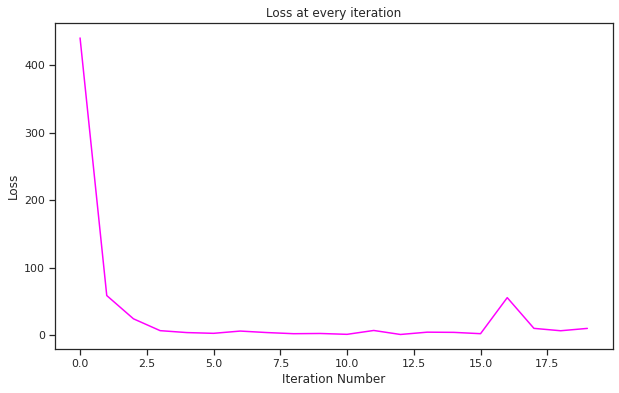

In [72]:
# Training
laptop_nlp = train_spacy(laptop_train, 20)

In [76]:
# Save our trained model into a new directory
laptop_nlp.to_disk('laptop_big_nlp')

In [77]:
# !zip -r laptop_big_nlp.zip laptop_big_nlp

In [78]:
# Serializing
pickle.dump(laptop_nlp, open('laptop_big_nlp.pkl', "wb"), protocol=pickle.HIGHEST_PROTOCOL)

## Testing stuff

In [79]:
# Testing out the results

def extract_entities(user_input, visualize = False):
    # Loading it in
    laptop_nlp = pickle.load(open("laptop_big_nlp.pkl", "rb"))
    doc = laptop_nlp(user_input)
    extracted_entities = []
    ents = list_query_ents(user_input)

    # These are the objects you can take out
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))
    for i in ents:
        extracted_entities.append(i)
    # If you want to visualize
    # if visualize == True:
    #     # Visualizing with displaCy how the document had it's entity tagged (runs a server)
    #     colors = {"product_type": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    #     options = {"ents": ["product_type"], "colors": colors}
    #     html = displacy.render(doc, style = 'ent', options = options)
    #     display(HTML(html));
    #     displacy.serve(doc, style="ent", options=options)
    #     displacy.serve(doc, style="ent")
    return extracted_entities

In [80]:
# best case user query scenario (as almost every entity to find 1 specific product)

test_text = 'I want an hp omen laptop whose ram is bigger than 8 gb and size is lesser than 16 inches and weight is between 1.5 kg to 1.8 kg'

In [81]:
print(extract_entities(test_text, visualize = True))

[('omen', 13, 17, 'product_name'), ('laptop', 18, 24, 'product_type'), ('hp', 10, 12, 'brand'), ('8 gb', 50, 54, 'ram'), ('16 inches', 79, 88, 'size'), ('1.5 kg', 111, 117, 'weight'), ('1.8 kg', 121, 127, 'weight'), ('size_below', 0, 0, 'size_category'), ('weight_range', 0, 0, 'weight_category'), ('ram_above', 0, 0, 'ram_category')]


In [82]:
# 'va.' in laptop_nlp.vocab.strings

## Adding more items and resuming training

In [83]:
# Now we re-train the recognizer
def retrain_spacy(train_data, iterations):
    nlp = pickle.load(open("laptop_big_nlp.pkl", "rb"))

    count = 0
    # Add labels
    for _, annotations in train_data:
         for ent in annotations.get('entities'):
            count += 1
            ner.add_label(ent[2])

    print(count)
    # Disable all pipes other than 'ner' during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.resume_training()
        
        train_loss = []
        
        # Go through the training data N times
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            
            # Shuffle training data
            random.shuffle(train_data)
            
            # Iteration level metrics
            losses = {}
            misalligned_count = 0
            
            # Iterating through every sentence
            for text, annotations in train_data:    
                # try:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
                # print('lol wthhhhhhhhh bro this shit is not misaligned howwwwww')
                # except ValueError as e:
                #     misalligned_count += 1
                #     # If it goes here, that means there's a misaligned entity
                #     print(f'Ignoring misaligned entity...\n{(text,annotations)}')
                #     pass
                
            # Enable this is you want to track misalliged counts
            print(f'-- misalligned_count (iteration {itn}): {misalligned_count}')
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (iteration {itn}): {losses}')
            
        # Visualizing the loss
        plt.figure(figsize=(10,6))
        plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
        plt.title('Loss at every iteration')
        plt.xlabel('Iteration Number')
        plt.ylabel('Loss')
        plt.show()
            
    return nlp

In [84]:
# laptop_nlp = retrain_spacy(laptop_train, 20)

# Intent Classifier

In [2]:
import pandas as pd
import numpy as np
#Importing the dataset
test = pd.read_csv('t1.csv')
train = pd.read_csv('intent_train.csv')

In [3]:
train

,intent,text
0,Price_info,What is the price range of HP pavillion laptops?
1,Price_info,What is the cost of ASUS TUF Gaming A17 Ryzen ...
2,Price_info,What is the price of acer Aspire 7 ryzen 5?
3,Price_info,What is the price range of dell Laptops?
4,Price_info,How much does a MSI Bravo Ryzen 5 cost?
5,Price_info,How much does a MSI GF63 laptop cost?
6,Price_info,What is the price of Lenovo IdeaPad?
7,Price_info,How much does a 17 inch gaming laptop cost?
8,Price_info,What is the price of HP OMEN laptop?
9,Price_info,What is the price range of ASUS Laptops?


In [4]:
test

,intent,text
0,Specs_info,What is the size of DELL Inspiron 15 7000 laptop?
1,Specs_info,How big is the screen of acer Predator Helios ...
2,Specs_info,what is the range of the screen size of MSI la...
3,yes,"yep, that's true"
4,yes,"yes, that is actually true"
5,yes,"yes, that's it"
6,yes,"yes, that is right"
7,Comparison_info,Is the MSI GF65 Laptop Thin less expensive tha...
8,Comparison_info,Is acer Nitro 5 Ryzen 7 heavier than MSI Bravo...
9,Comparison_info,Is the HP Omen Ryzen 7 laptop superior to the ...


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

In [22]:
import tarfile
file = tarfile.open('universal-sentence-encoder-large_4.tar.gz')
  
# extracting file
file.extractall('/universal-encoder')
  
file.close()

EOFError: Compressed file ended before the end-of-stream marker was reached

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import tensorflow_hub as hub
import keras
import keras.backend as K
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Bidirectional, LSTM
import pickle    
import os
input_text1 = Input(shape=(512,))
x = Dense(256, activation='relu')(input_text1)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

model=Model(inputs=[input_text1], outputs=norm_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               8320  

In [7]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [8]:
nn4_small2_train.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          157120      input_2[0][0]                    
                                                                 input_3[0][0]              

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               8320  

In [9]:
unique_train_label=np.array(train['intent'].unique().tolist())
labels_train=np.array(train['intent'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

In [10]:
def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k,train_set,unique_train_label,map_train_label_indices,embed):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a=train_set.iloc[idxs_a].values.tolist()
      b=train_set.iloc[idxs_p].values.tolist()
      c=train_set.iloc[idxs_n].values.tolist()

      a = embed(a)
      p = embed(b)
      n = embed(c)
        # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [a,p,n], []

In [11]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit(get_triplets_batch(128,train['text'],unique_train_label,map_train_label_indices,embed), epochs=20,steps_per_epoch=10, callbacks=[cp_callback])

Epoch 1/20
10/10 [==============================] - 9s 931ms/step - loss: 34.0341

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/20
10/10 [==============================] - 9s 906ms/step - loss: 18.6145

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/20
10/10 [==============================] - 9s 899ms/step - loss: 13.5588

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/20
10/10 [==============================] - 9s 904ms/step - loss: 11.5291

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/20
10/10 [==============================] - 9s 921ms/step - loss: 10.2218

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/20
10/10 [==============================] - 9s 899ms/step - loss: 7.6753

Epoch 00006: saving model to training_1/cp.ckpt
Epoch 7/20
10/10 [==============================] - 9s 890ms/step - loss: 7.2630

Epoch 00007: saving model to training_1/cp.ckpt
Epoch 8/20
10/10 [==============================] - 9s 904ms/step - loss: 5.9098

Epo

In [95]:
nn4_small2_train.save("./gocha_model")

INFO:tensorflow:Assets written to: ./gocha_model/assets


INFO:tensorflow:Assets written to: ./gocha_model/assets


In [ ]:
help(nn4_small2_train)

In [97]:
#nn4_small2_train.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

In [17]:
X_train = model.predict(np.array(embed(np.array(train['text'].values.tolist()))['outputs']))
X_test = model.predict(np.array(embed(np.array(test['text'].values.tolist()))['outputs']))

y_train = np.array(train['intent'].values.tolist())
y_test = np.array(test['intent'].values.tolist())

In [99]:
X_train

array([[ 0.11542503, -0.01493962,  0.09493823, ...,  0.14228247,
         0.04998688,  0.01188562],
       [ 0.09320247, -0.02410054,  0.11080985, ...,  0.12646317,
         0.04677477,  0.01345398],
       [ 0.09457887, -0.01719765,  0.10426898, ...,  0.14232305,
         0.05586661,  0.0430698 ],
       ...,
       [-0.14394952, -0.16898383,  0.04665462, ..., -0.17704226,
        -0.00936383,  0.02991731],
       [-0.1291222 , -0.17012097,  0.0215052 , ..., -0.17500019,
        -0.00471359,  0.04125756],
       [-0.13068236, -0.1460376 , -0.00109938, ..., -0.15505067,
        -0.04331025,  0.05343954]], dtype=float32)

In [15]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import sklearn

In [13]:
import pickle

In [18]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
#model.fit(X_train, Y_train)
# save the model to disk
filename = 'svc.sav'
pickle.dump(svc, open(filename, 'wb'))
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
y_pred_knn = knn.predict(X_test)
acc_knn = sklearn.metrics.accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc =sklearn.metrics.accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 1.0, SVM accuracy = 1.0


In [102]:
from sklearn import metrics
print(metrics.classification_report(list(y_test), list(y_pred_knn)))

                 precision    recall  f1-score   support

       Buy_info       1.00      1.00      1.00         6
Comparison_info       1.00      1.00      1.00         3
     Price_info       1.00      1.00      1.00         3
     Specs_info       1.00      1.00      1.00         3
            yes       1.00      1.00      1.00         4

       accuracy                           1.00        19
      macro avg       1.00      1.00      1.00        19
   weighted avg       1.00      1.00      1.00        19



In [103]:
import matplotlib.pyplot as plt

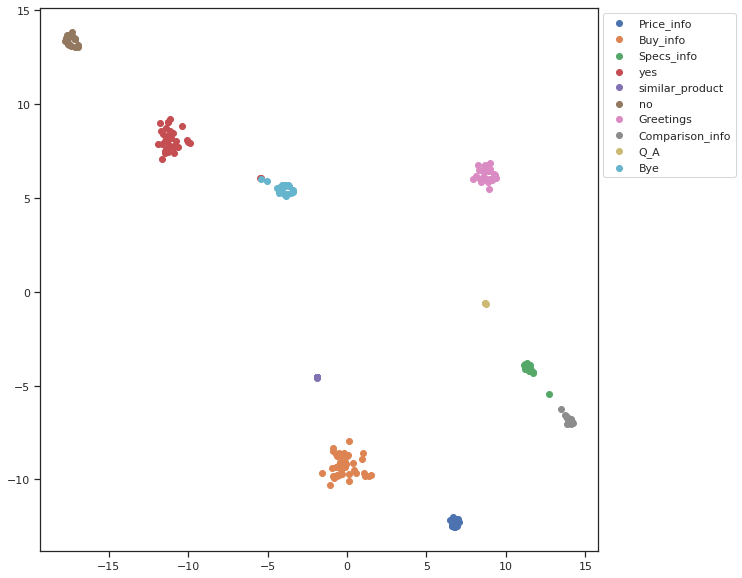

In [104]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_train)):
    idx = y_train == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

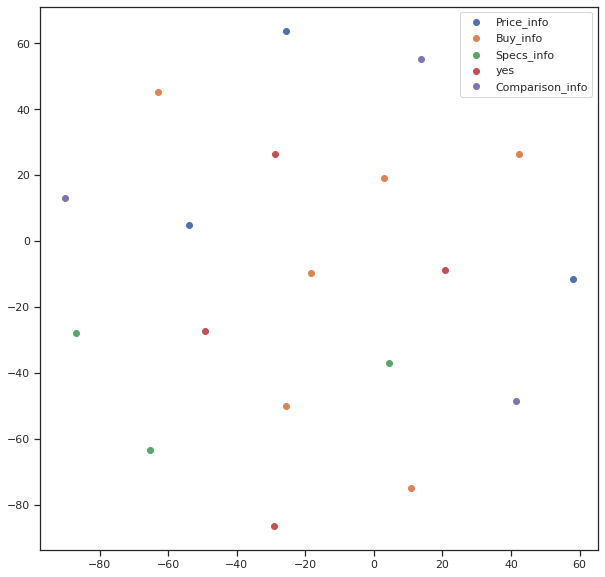

In [105]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [106]:
type(test['text'])

pandas.core.series.Series

# Similarity Search

In [107]:
#Importing libraries
import numpy as np
import pandas as pd               

In [108]:
#Loading the dataset
df=pd.read_csv('dataset 1 - Sheet1.csv')
df.head()

,Device,Question,Answer
0,Mouse,What kind of mouse can I buy?,There are many types of computer mouse and tra...
1,Mouse,"What are the differences between wired mouse, ...",While a wired mouse is powered by the connecti...
2,Mouse,What is the difference between a gaming and no...,Gaming mice are special mice that are more sui...
3,Mouse,Does a mouse need some sort of mousepad to fun...,If your mouse works without one and you can us...
4,Mouse,"What is the difference between speed, control ...","Hard pads, like most other mice pads on the ma..."


In [109]:
len(df)

65

In [110]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /opt/conda/lib/python3.6/site-packages (2.2.2)
Note: you may need to restart the kernel to use updated packages.


In [111]:
from sentence_transformers import SentenceTransformer
model1 = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Data we want to encode.
sentences = df["Question"]

#Encoding the Data
embedding = model1.encode(sentences)

In [112]:
embedding[0]

array([-0.54845774, -0.626686  ,  0.2290452 , -0.4008185 ,  0.515229  ,
       -0.14523472,  0.30904114, -0.20325539, -0.03383248, -0.10069148,
        0.0483859 ,  0.6717774 , -0.3435106 ,  0.9427713 , -0.0729778 ,
       -0.12937084,  0.01744375,  0.44503212,  0.44455522,  0.70203096,
        0.31840947, -0.3439595 ,  0.60153115, -0.35885134, -0.8782538 ,
        0.3313779 ,  0.33945265, -0.03420896, -0.16906415, -0.26718172,
        0.11229663, -0.34284943, -0.10299845, -0.74393547, -0.26200476,
       -0.45236206, -0.3328684 ,  0.07903847, -0.02002365, -0.48617148,
       -0.12343071,  0.4917013 ,  0.17491618,  0.47863775,  0.17800677,
        0.32494494, -0.0193498 ,  0.0786403 ,  0.26561365,  0.10317294,
        0.28596157, -0.51926386, -0.2850198 , -0.24214017, -0.12374765,
        0.45394263,  0.0782603 , -0.23630615,  0.15103325,  0.18310615,
       -0.28082934, -0.2301538 ,  0.08753999,  0.16000625,  0.37651706,
       -0.28809816, -0.9938928 ,  0.2695897 , -0.63033956,  0.17

In [113]:
len(embedding[0])

384

In [114]:
#Defining cosine similarity function
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [115]:
#Using similarity values to answer queries

def Q_A(query):
  # while(True):
      # query = input("User: ")
      query_vec = model1.encode([query])[0]
      sim=[]
      for sent in sentences:
          sim.append(cosine(query_vec, model1.encode([sent])[0]))
      if(max(sim)>0.4):
          print("Dorami: ", df['Answer'][sim.index(max(sim))])
      else:
          print("Dorami: Sorry, I could not understand.")
      #     continue
      # if(df['Answer'][sim.index(max(sim))]=="Thank you! See you again."):
      #     break

# Action code

In [20]:
user_query1 = 'I want an hp omen laptop with ram more than 8 gb'

In [21]:
user_query = model.predict(np.array(embed(np.array(pd.Series(user_query1).values.tolist()))['outputs']))

In [118]:
intent = svc.predict(user_query)
entities = extract_entities(user_query1)

In [119]:
intent

array(['Buy_info'], dtype='<U15')

In [120]:
entities2 = [(entity[0], entity[3]) for entity in entities]
entities2

[('omen', 'product_name'),
 ('laptop', 'product_type'),
 ('hp', 'brand'),
 ('8 gb', 'ram'),
 ('ram_above', 'ram_category')]

In [121]:
def Convert(tup, di):
    for b, a in tup:
        di.setdefault(a, []).append(b)
    return di
      
# Driver Code    
tups = entities2
dictionary = {}
entity_dict = Convert(tups, dictionary)
entity_dict

{'product_name': ['omen'],
 'product_type': ['laptop'],
 'brand': ['hp'],
 'ram': ['8 gb'],
 'ram_category': ['ram_above']}

In [122]:
entity_dict.keys()

dict_keys(['product_name', 'product_type', 'brand', 'ram', 'ram_category'])

In [123]:
dflist = pd.read_csv('prod_gaming_laptops - flipkart-scraper_8077.csv')
dflist.title = dflist.title.map(lambda x: x.lower())
dflist

,title,title_link,image,price,size,ram,weight,Additional specs,color
0,hp pavilion ryzen 5 hexa core 5600h - (8 gb/51...,https://www.flipkart.com/hp-pavilion-ryzen-5-h...,https://rukminim1.flixcart.com/image/612/612/k...,"₹55,990",15.6 inch,8 GB,1.98 kg,NaN,Shadow Black
1,asus tuf gaming a17 ryzen 7 octa core 4800h - ...,https://www.flipkart.com/asus-tuf-gaming-a17-r...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",17.3 inch,16 GB,2.60 kg,NaN,Graphite Black
2,acer aspire 7 core i5 10th gen - (8 gb/512 gb ...,https://www.flipkart.com/acer-aspire-7-core-i5...,https://rukminim1.flixcart.com/image/612/612/k...,"₹52,990",15.6 inch,8 GB,2.15 Kg,NaN,Black
3,dell g15 ryzen 5 hexa core 5600h - (8 gb/512 g...,https://www.flipkart.com/dell-g15-ryzen-5-hexa...,https://rukminim1.flixcart.com/image/612/612/l...,"₹73,990",15.6 Inch,8 GB,2.4 kg,With MS Office,Phantom Grey
4,acer nitro 5 ryzen 7 octa core 5800h - (16 gb/...,https://www.flipkart.com/acer-nitro-5-ryzen-7-...,https://rukminim1.flixcart.com/image/612/612/k...,"₹94,990",15.6 inch,16 GB,2.4 kg,NaN,Black
5,msi bravo ryzen 5 hexa core 5600h - (8 gb/512 ...,https://www.flipkart.com/msi-bravo-ryzen-5-hex...,https://rukminim1.flixcart.com/image/612/612/k...,"₹54,990",15.6 inch,8 GB,2.35 Kg,NaN,Black
6,msi gf63 thin core i5 9th gen - (8 gb/512 gb s...,https://www.flipkart.com/msi-gf63-thin-core-i5...,https://rukminim1.flixcart.com/image/612/612/k...,"₹57,999",15.6 inch,8 GB,1.86 kg,NaN,Black
7,acer aspire 7 ryzen 5 hexa core 5500u - (8 gb/...,https://www.flipkart.com/acer-aspire-7-ryzen-5...,https://rukminim1.flixcart.com/image/612/612/k...,"₹54,990",15.6 inch,8 GB,2.15 kg,NaN,Black
8,lenovo ideapad gaming 3 core i5 10th gen - (8 ...,https://www.flipkart.com/lenovo-ideapad-gaming...,https://rukminim1.flixcart.com/image/612/612/k...,"₹53,490",15.6 inch,8 GB,2.2 kg,NaN,Onyx Black
9,asus vivobook gaming core i7 10th gen - (16 gb...,https://www.flipkart.com/asus-vivobook-gaming-...,https://rukminim1.flixcart.com/image/612/612/k...,"₹64,990",15.6 inch,16 GB,2.14 kg,NaN,Star Black


In [124]:
def intents_ent(uq):
    user_query1 = model.predict(np.array(embed(np.array(pd.Series(uq).values.tolist()))['outputs']))
    intent = svc.predict(user_query1)
    entities = [(entity[0].lower(), entity[3].lower()) for entity in extract_entities(uq)]
    tups = entities
    dictionary = {}
    entity_dict = Convert(tups, dictionary)

    return intent, entity_dict


In [125]:
# uq = input('User: ')
    
# # capturing intents and entities
# intent, en = intents_ent(uq)
# print(intent, en)

In [326]:
# sql_search(en)

In [126]:
# for finding the specific product(s) from the database
def sql_search(entity_dict):
    # df2 = df[df['title'].str.contains(entities[])
    value1 = list(entity_dict.values())[0]
    Bool = dflist['title'].str.contains(value1[0])

    print(entity_dict)
    for key, value in entity_dict.items():
      if key == 'ram':
        Bool1 = dflist['title'].str.contains(value[0] + "/") 
#         Bool1 = dflist['title'].str.contains(value[0] + "/") | dflist['specs'].str.contains(value[0])
      else:
        Bool1 = dflist['title'].str.contains(value[0])
#         Bool1 = dflist['title'].str.contains(value[0]) | dflist['specs'].str.contains(value[0])
      Bool1 = (Bool & Bool1)
      Bool = Bool1
    
    df2 = dflist[Bool]
    return df2
    # output = 'Dorami: These are all the'
    # for key in entity_dict.keys():
    #   output += ' ' + entity_dict[key][0]
  
    # output += ' in our catalogue. You can choose any one of them or even give me more specifications that you want so I can narrow down the results for you!'
    # print(output, df2.title, sep='\n')


In [127]:
# to capture missing entities
def missing_entity(missing_entity, product_type, entity_dict):
    if '_' in missing_entity:
      print('Dorami: Is there any specific {} in which you want the {} or anything will do?'.format(' '.join(missing_entity.split('_')), product_type))
    else:
      print('Dorami: Is there any specific {} in which you want the {} or anything will do?'.format(missing_entity, product_type))
    user_query = input('User: ')
    # capturing intents and entities
    intent, missing_entity_dict = intents_ent(user_query)
    print(intent, missing_entity_dict)

    if intent == 'no':
      return dict()
    else:
      return missing_entity_dict

In [128]:
def comp_search(entity_dict):
    # df2 = df[df['title'].str.contains(entities[])
    value1 = list(entity_dict.values())[0][0]
    value2 = list(entity_dict.values())[0][1]
    Bool1 = dflist['title'].str.contains(value1)
    Bool2 = dflist['title'].str.contains(value2)
    df1 = dflist[Bool1]
    df2 = dflist[Bool2]
    # print(df1.title)
    # print(df2.title)
    value1 = list(entity_dict.values())[1]
    Bool = df1['title'].str.contains(value1[0])
  
    for value in entity_dict.values(): 
      Bool1 = df1['title'].str.contains(value[0]) | df1['specs'].str.contains(value[0])
      Bool1 = (Bool & Bool1)
      Bool = Bool1
    
    df11 = df1[Bool]
    
    value2 = list(entity_dict.values())[1]
    print(value2)
    Bool = df2['title'].str.contains(value2[1])
    # print(df11)
    # print('2nd')
    for value in entity_dict.values(): 
      # if(value not in value2[0] ):
        Bool1 = df2['title'].str.contains(value[0]) | df2['specs'].str.contains(value[0])
        Bool1 = (Bool | Bool1)
        Bool = Bool1
    # print(Bool)
    df22 = df2[Bool]
    #print(df22)
    print('Dorami: Product 1 specs', df11.title , df11.specs , df11.price, sep='\n' )
    print('Dorami: Product 2 specs', df22.title , df22.specs , df22.price , sep='\n' )
    return

In [129]:
past_intents = []
past_entities = []

In [156]:
def chatbot(user_query = None):
    if user_query == None:
      user_query = input('You: ')
    
    # capturing intents and entities
    intent, entity_dict = intents_ent(user_query)

    # just to check if code capturing right intents and entitites
    print(intent,entity_dict)
    
    # when Dorami asks the user more details to narrow the search results
    if past_intents != [] and past_intents[-1] == 'Buy_info':
      print(past_intents[-1] )
      past_entity_dict = past_entities[-1]
      past_entity_dict.update(entity_dict)
      if 'brand' not in past_entity_dict.keys():
          missing_entity_dict = missing_entity('brand', past_entity_dict['product_type'][0], past_entity_dict)
          past_entity_dict.update(missing_entity_dict)
      if 'product_name' not in past_entity_dict.keys():
          missing_entity_dict = missing_entity('product_name', past_entity_dict['product_type'][0], past_entity_dict)
          past_entity_dict.update(missing_entity_dict)
      if 'colour' not in past_entity_dict.keys():
          missing_entity_dict = missing_entity('colour', past_entity_dict['product_type'][0], past_entity_dict)
          past_entity_dict.update(missing_entity_dict)
      
      # appending spec_info intent at the end of intents list to avoid going into this if clause again in the next chatbot func iteration
      past_intents.append('spec_info')
#       return(past_entity_dict)
      print(past_entity_dict)
      query_df = sql_search(past_entity_dict)
#       return('Dorami: These are the products I found based on your specifications, is this what you are looking for?', query_df.title, sep='\n')
      print('Dorami: These are the products I found based on your specifications, is this what you are looking for?', query_df.title, sep='\n')

      chatbot()

    # storing the intents and entities for use in above scenario and dialogue context tracking
    past_intents.append(intent)
    past_entities.append(entity_dict)

    # q_a intent
    if intent == 'Q_A':
      Q_A(user_query)
      chatbot()

    # buy_info
    elif intent == 'Buy_info':
      if 'laptop' in entity_dict['product_type']:
        # print(entity_dict)
        dict_ents_iterable = ['price','size','ram','weight']
        for entity in dict_ents_iterable:
            if str(str(entity)+'_category') in entity_dict:
                if str(str(entity)+'_above') in entity_dict[str(str(entity)+'_category')]:
                  price_cap_int = ''.join(filter(lambda i: i.isdigit(), entity_dict[str(entity)][0]))
#                   print(price_cap_int)
                  entity_dict.pop(str((entity)))
                  entity_dict.pop(str(str(entity)+'_category'))
                  # print(entity_dict)
                  dfprice = sql_search(entity_dict)
                  # for row in dfprice:
                  for (row,series) in dfprice.iterrows():
                    price_dat_int = ''.join(filter(lambda i: i.isdigit(), series[3+dict_ents_iterable.index(entity)]))
#                     print(price_dat_int)
                    if price_dat_int > price_cap_int:
        #               return(series[0],series[3])
                      print(series[0],series[3+dict_ents_iterable.index(entity)])
                  chatbot()
                elif str(str(entity)+'_below') in entity_dict[str(str(entity)+'_category')]:
                  price_cap_int = ''.join(filter(lambda i: i.isdigit(), entity_dict[str(entity)][0]))
#                   print(price_cap_int)
                  entity_dict.pop(str((entity)))
                  entity_dict.pop(str(str(entity)+'_category'))
                  # print(entity_dict)
                  dfprice = sql_search(entity_dict)
                  # for row in dfprice:
                  for (row,series) in dfprice.iterrows():
                    price_dat_int = ''.join(filter(lambda i: i.isdigit(), series[3+dict_ents_iterable.index(entity)]))
#                     print(price_dat_int)
                    if price_dat_int < price_cap_int:
        #               return(series[0],series[3])
                      print(series[0],series[3+dict_ents_iterable.index(entity)])
                  chatbot()
                elif str(str(entity)+'_around') in entity_dict[str(str(entity)+'_category')]:
                  t = 0
                  price_cap_int = ''.join(filter(lambda i: i.isdigit(), entity_dict[str(entity)][0]))
                  entity_dict.pop(str((entity)))
                  entity_dict.pop(str(str(entity)+'_category'))
                  # print(entity_dict)
                  dfprice = sql_search(entity_dict)
                  prod_ar = []
                  for (row,series) in dfprice.iterrows():
                    price_dat_int = ''.join(filter(lambda i: i.isdigit(), series[3+dict_ents_iterable.index(entity)]))
                    if abs(int(price_dat_int) - int(price_cap_int))<abs(int(t)-int(price_cap_int)):
                      t = price_dat_int
                  for (row,series) in dfprice.iterrows():
                    price_dat_int = ''.join(filter(lambda i: i.isdigit(), series[3+dict_ents_iterable.index(entity)]))
                    if t == price_dat_int:
                      prod_ar.append(series[0])
                      prod_ar.append(series[3+dict_ents_iterable.index(entity)])
        #           return(prod_ar)
                  print(prod_ar)
                  chatbot()
                elif str(str(entity)+'_range') in entity_dict[str(str(entity)+'_category')]:
                  a = ''.join(filter(lambda i: i.isdigit(), entity_dict[str(entity)][0]))
                  b = ''.join(filter(lambda i: i.isdigit(), entity_dict[str(entity)][1]))
                  price_cap_int_low = min(a,b)
                  price_cap_int_high = max(a,b)
                  entity_dict.pop(str((entity)))
                  entity_dict.pop(str(str(entity)+'_category'))
                  # print(entity_dict)
                  dfprice = sql_search(entity_dict)
                  # for row in dfprice:
                  for (row,series) in dfprice.iterrows():
                    price_dat_int = ''.join(filter(lambda i: i.isdigit(), series[3+dict_ents_iterable.index(entity)]))
                    if price_cap_int_low <price_dat_int < price_cap_int_high:
        #               return(series[0],series[3])
                      print(series[0],series[3+dict_ents_iterable.index(entity)])
                  chatbot()
          
        else:
          query_df = sql_search(entity_dict)
          output = 'Dorami: These are all the'
          for key in entity_dict.keys():
            output += ' ' + entity_dict[key][0]
          output += ' in our catalogue. You can choose any one of them or even give me more specifications that you want so I can narrow down the results for you!'
#           return(output, query_df.title, sep='\n')
          print(output, query_df.title, sep='\n')
          chatbot()


    # greetings intent
    elif intent == 'Greetings':
      return('Dorami:Hello, I am Dorami. How can I help you?')
#       print('Dorami:Hello, I am Dorami. How can I help you?')
      chatbot()

    # price_info intent
    elif intent == 'Price_info':
      dfnew = sql_search(entity_dict)
      return('Dorami: The price of the requested products are shown below:-')
#       print('Dorami: The price of the requested products are shown below:-')
      for (row,series) in dfnew.iterrows():
        return(series[0],series[3])
#         print(series[0],series[3])
      chatbot()
        
    # bye intent
    elif intent == 'bye':
      print('Dorami:It was nice talking with you, do you want help with anything else?')
      user_query = input('User: ')
      intent, entity_dict = intents_entities(user_query)
      if intent == 'no' :
        return('Dorami:Okay see you later. Have a good day!!! \nWe also have some other similar products which you may like?')
#         print('Dorami:Okay see you later. Have a good day!!! \nWe also have some other similar products which you may like?')
        sql_search_sim(entity_dict)
      else :
        chatbot(user_query)

    # yes intent
    elif intent == 'yes':
      return('Dorami:I am happy that this is what you want!! Do you want any other help?')
#       print('Dorami:I am happy that this is what you want!! Do you want any other help?')
      user_query = input('User: ')

      # capturing intents and entities
      intent, entity_dict = intents_ent(user_query)
      if intent == 'no':
        return('Dorami: Have a good day!!')
#         print('Dorami: Have a good day!!')
      else:
        chatbot(user_query)


    # no intent
    elif intent == 'no':
      # print(past_intents)
      # if past_intents[-1]== 'yes':
      #   print('Dorami:Have a good day!!')
      #   pass
      # else:  
        replies = ['If you want any specific product you can provide me more details such as the specific brand name, product name or technical specifications too',
                  'I am sorry you did not like the products, you can chose to give me more details or contact Otsuka Shokai Sales for further inquiry',
                  'I am sorry you did not like the products I showed, can I know some more details about the kind of product you wanna see so I can show you better products?']
        return('Dorami:', random.choice(replies))
#         print('Dorami:', random.choice(replies))
        chatbot()

    # similar product intent
    elif intent == 'similar_product':
      # if 'price' or 'spec' not in entity_dict.keys():
      #   print('Dorami: You want similar products based on ?')
      #   val = input('User: ')
      #   if intent == 'no' :
      #     sql_search_sim(entity_dict)
      similar_entity_dict = entity_dict.copy()
      brands = list(dfo.brand.unique())
      similar_entity_dict['brand'] = random.choice(brands)
      similar_entity_dict.pop('product_name')
      return(similar_entity_dict)
#       print(similar_entity_dict)
      sql_search(similar_entity_dict)

    elif intent == 'Comparison_info':
      if 'product_name' not in entity_dict.keys():
        return('What models do you want to compare?')
#         print('What models do you want to compare?')
        user_query = input('User: ')
         # capturing intents and entities
        intent_n, missing_entity_dict = intents_ent(user_query)
        entity_dict.update(missing_entity_dict)
      comp_search(entity_dict)

    # spec info intent
    if intent == 'Specs_info':
      sql_search(entity_dict)
      chatbot()

    # for dialogue context tracking

In [ ]:
# clearing the stored past intents and entities
past_intents.clear()
past_entities.clear()

# calling Dorami
chatbot()

You:  show me a dell laptop whose ram is nearly around 16 gb


['Buy_info'] {'product_type': ['laptop'], 'brand': ['dell'], 'ram': ['16 gb'], 'ram_category': ['ram_around']}
{'product_type': ['laptop'], 'brand': ['dell']}
['dell inspiron 5518 core i5 11th gen - (16 gb/512 gb ssd/windows 10 home) inspiron 5518 laptop (15.6 inch, silver, 1.65 kg, with ms office)', '16 GB', 'dell core i5 11th gen - (16 gb/512 gb ssd/windows 11 home/4 gb graphics/nvidia geforce rtx 3050 ti/120 hz) g15-5511 gaming laptop  (15.6 inch, dark shadow grey, 2.65 kg, with ms office)', '16 GB']


In [ ]:
#from dorami import chatbot
from flask import Flask, request
app = Flask(__name__)
 

In [ ]:
@app.route('/')
def hello_name():
	input_string = request.get_json()['input_string']
	res = chatbot(input_string) # res should be a dict
	#res={
	#	"data": "These are the laptop",
	#	"img_url": "http..."
	#}
	return res

if __name__ == '__main__':
	app.run(debug=True)

In [ ]:
if __name__ == '__main__':
	app.run(debug=True)

In [ ]:

# if intent == 'Buy_info':
#   if 'laptop' in entity_dict['product_type']:
#     if 'price' not in entity_dict.keys():
#       missing_entity('price', entity_dict['product'])
#     elif

In [ ]:
# df2 = df[df['title'].str.contains('hp') & df['title'].str.contains('omen')]
# df2.iloc[0]['title_link']

In [ ]:
# a = []
# b = {'tree': 'palm', 'car': 'honda baby'}
# c = {'yo': 'yo yo yo yoo', 'bro': 'bro bro broo'}